<a href="https://colab.research.google.com/github/jorgemm83/prueba_tecnica/blob/main/Prueba_t%C3%A9cnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

En esta prueba técnica estaremos trabajando con los datos de Alpha Vantage sobre la acción de IBM a intervalos de 5 minutos los cuales contienen información detallada sobre las transacciones de la acción durante cada período de 5 minutos. En este caso en particular tenemos datos desde el 26 de agosto del 2024 a las 4 am hasta el 23 de septiembre de 2024 hasta las 7.55 pm.

A continuación se describen los diferentes datos que podemos obtener al realizar la consulta a la API de Alpha Vantage para esta acción con la función de intervalos de 5 minutos.

#Descripción de los datos:

1. **Timestamp (Fecha y hora)**

Cada registro está etiquetado con una marca de tiempo que indica la fecha y la hora exacta del intervalo de 5 minutos. Estos tiempos están en UTC (Tiempo Universal Coordinado).

Ejemplo: 2023-09-23 16:35:00.

2. **Open (Apertura)**

El precio de apertura de la acción de IBM al inicio de cada intervalo de 5 minutos. Representa el primer precio al que se negoció la acción en ese período.

Ejemplo: 142.20 USD.

3. **High (Máximo)**

El precio más alto alcanzado por la acción de IBM durante ese intervalo de 5 minutos. Es el precio más alto al que se negoció la acción en dicho período.

Ejemplo: 142.35 USD.

4. **Low (Mínimo)**

El precio más bajo alcanzado por la acción de IBM en ese intervalo de 5 minutos. Representa el precio más bajo al que se negoció la acción en ese período.

Ejemplo: 141.90 USD.

5. **Close (Cierre)**

El precio de cierre de la acción de IBM al final del intervalo de 5 minutos. Es el último precio registrado al final de ese período.

Ejemplo: 142.10 USD.

6. **Volume (Volumen)**

El número de acciones de IBM que fueron negociadas durante ese intervalo de 5 minutos. Indica cuántas transacciones ocurrieron en ese periodo, lo que puede mostrar la liquidez y el interés del mercado.

Ejemplo: 2500 acciones.

# **Descripción general:**
Los datos se actualizan cada 5 minutos durante las horas de negociación del mercado. Esto permite realizar un análisis intradía detallado de los movimientos del precio de la acción de IBM. Estos datos son muy valiosos para los traders intradía que buscan identificar patrones de precios a corto plazo, como tendencias, puntos de soporte y resistencia, y para determinar el momentum de la acción en períodos breves. Finalmente,el volumen negociado en cada intervalo es útil para medir la intensidad de las transacciones. Un volumen alto puede indicar un fuerte interés de compra o venta en ese período.

#1. Instalación de bibliotecas necesarias

In [1]:
!pip install requests pandas scikit-learn

#2. Obtención de datos Financieros
Vamos a usar datos históricos de acciones a través de la API de Alpha Vantage para variables como precios de apertura, cierre, volumen, etc.

In [2]:
import requests
import pandas as pd


def get_financial_data(symbol: str, interval: str):
    #API_KEY = os.getenv('API_KEY')
    API_KEY = 'POK20BXESBQBLR4J'
    URL_API = 'https://www.alphavantage.co/query'

    params = {
        'function': 'TIME_SERIES_INTRADAY',
        'symbol': symbol,
        'interval':interval,
        'outputsize': 'full',
        'apikey': API_KEY,
        'datatype': 'json'
    }


    # Realizar la solicitud GET a la API
    response = requests.get(URL_API, params)

    # Verificar si la solicitud fue exitosa (código 200)
    if response.status_code == 200:
        data = response.json()  # Convertir la respuesta a formato JSON

        #print(data)

         # Comprobar si la respuesta contiene datos válidos
    if "Time Series ("+interval+")" not in data:
        raise ValueError("Error al obtener datos de la API")

    # Convertir los datos a un DataFrame
    df = pd.DataFrame.from_dict(data['Time Series ('+interval+')'], orient='index', dtype=float)

    # Renombrar columnas para que tengan nombres más intuitivos
    df.rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        '4. close': 'close',
        '5. volume': 'volume'
    }, inplace=True)

    # Convertir el índice a formato de fecha
    df['date'] = pd.to_datetime(df.index)
    # Procesar los datos
    df = df.sort_values('date')

    return df


# Obtener datos de IBM (IBM)
symbol = 'IBM'
interval='5min'
data = get_financial_data(symbol, interval)

data = data.reset_index(drop=True) #Resets the index and drops the old index
data = data.sort_values('date') #Sorts the values by date
data = data[['date', 'open', 'high', 'low', 'close', 'volume']] #Reorders the columns so 'date' is first
data.head()

,date,open,high,low,close,volume
0,2024-08-26 04:00:00,196.20,196.20,196.00,196.00,6.0
1,2024-08-26 04:05:00,195.80,196.38,195.68,196.28,176.0
2,2024-08-26 04:35:00,195.98,195.98,195.98,195.98,19.0
3,2024-08-26 04:40:00,196.28,196.28,196.28,196.28,1.0
4,2024-08-26 05:20:00,195.98,195.98,195.98,195.98,1.0


#EDA

Antes de construir modelos de machine learning es necesario realizar un análisis exploratorio de datos (EDA) completo y adecuado para el conjunto de datos financieros que estamos analizando (con las variables open, high, low, close, volume, y date). Para ello existen varias pruebas y análisis que podemos realizar. Además, se pueden aplicar varias técnicas de preprocesamiento. A continuación veremos un conjunto de pruebas EDA que podemos realizar con una breve explicación.

**1. Pruebas de EDA**

**1.1 Estadísticas descriptivas básicas**

Descripción: Aquí obtenemos estadísticas como el promedio, desviación estándar, valores máximos y mínimos para cada variable.

Propósito: Comprender la distribución general de los datos y detectar posibles outliers.

**1.2 Distribución de precios**

Descripción: En esta parte graficamos histogramas de las variables open, high, low, close, y volume.

Propósito: Ver cómo están distribuidos los datos y detectar posibles sesgos o distribuciones anormales.

**1.3 Análisis de correlación**

Descripción: Se crea una matriz de correlación para las variables financieras.

Propósito: Verificar la relación entre las variables (por ejemplo, si los precios de apertura y cierre están fuertemente correlacionados).

**1.4 Gráfico de series temporales**

Descripción: Graficar la evolución del precio de cierre (close) y el volumen (volume) a lo largo del tiempo.

Propósito: Analizar tendencias, estacionalidades, o patrones de comportamiento en el tiempo.

**1.5 Boxplot (diagrama de cajas)**
Descripción: Crear boxplots para detectar valores atípicos.

Propósito: Identificar posibles outliers que pueden influir en los modelos.

**2. Preprocesamiento**

Antes de usar los datos para modelos de machine learning, es importante hacer varios pasos de preprocesamiento:

**2.1 Imputación de valores faltantes**

Descripción: Rellenar valores faltantes o eliminarlos si existen en el conjunto de datos.

Propósito: Asegurar que no haya inconsistencias que afecten el rendimiento del modelo.

**2.2 Escalado de los datos**
Descripción: Normalizar o estandarizar las variables numéricas como open, high, low, close, volume.

Propósito: Algunas técnicas de machine learning (como la regresión lineal) requieren que los datos estén escalados para evitar que ciertas características dominen a otras.

**2.3 Generación de nuevas características**

Descripción: Crear nuevas variables como el rango de precios (high - low) o el cambio porcentual diario (close / open - 1).

Propósito: Incluir más información relevante que pueda mejorar la capacidad predictiva del modelo.

**2.4 Eliminación de outliers**

Descripción: Detectar y eliminar valores atípicos que puedan distorsionar el análisis.

Propósito: Reducir el ruido en los datos y mejorar la robustez del modelo.

# Análisis EDA

Estadísticas descriptivas:
                                date         open         high          low  \
count                           3362  3362.000000  3362.000000  3362.000000   
mean   2024-09-10 02:37:44.991076864   207.789804   207.934881   207.626791   
min              2024-08-26 04:00:00   195.424000   195.500000   184.360000   
25%              2024-09-03 11:51:15   200.879925   201.000000   200.740000   
50%              2024-09-10 17:40:00   204.870000   205.010000   204.610000   
75%              2024-09-17 18:48:45   214.820000   214.939900   214.700000   
max              2024-09-24 19:55:00   221.230000   221.598800   221.230000   
std                              NaN     7.613885     7.613970     7.619324   

             close        volume  
count  3362.000000  3.362000e+03  
mean    207.801150  4.551284e+04  
min     195.400000  1.000000e+00  
25%     200.891250  3.100000e+01  
50%     204.877500  1.109800e+04  
75%     214.820000  2.739725e+04  
max     221.2300

<Figure size 1200x600 with 0 Axes>

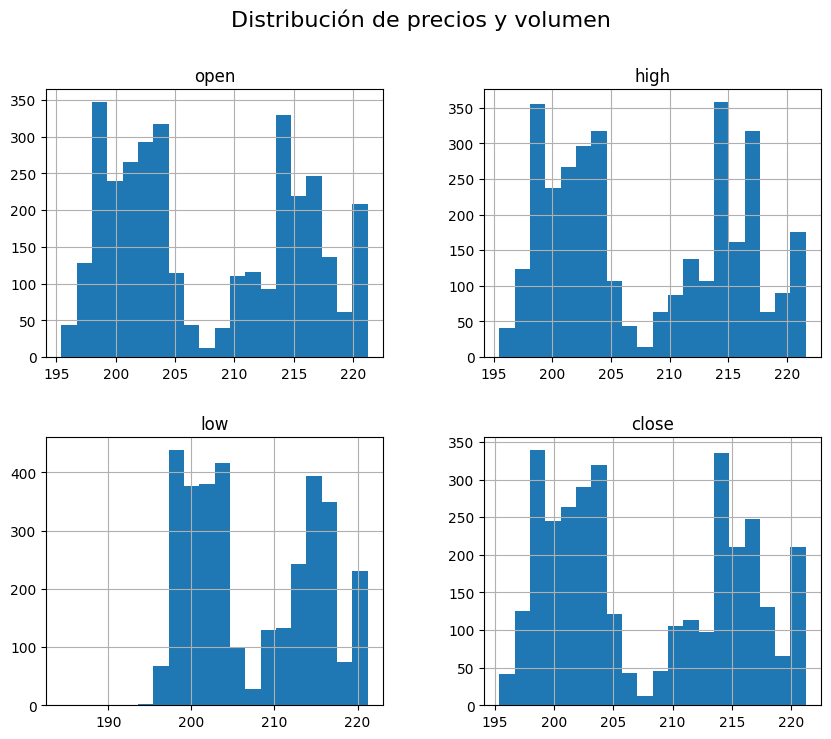

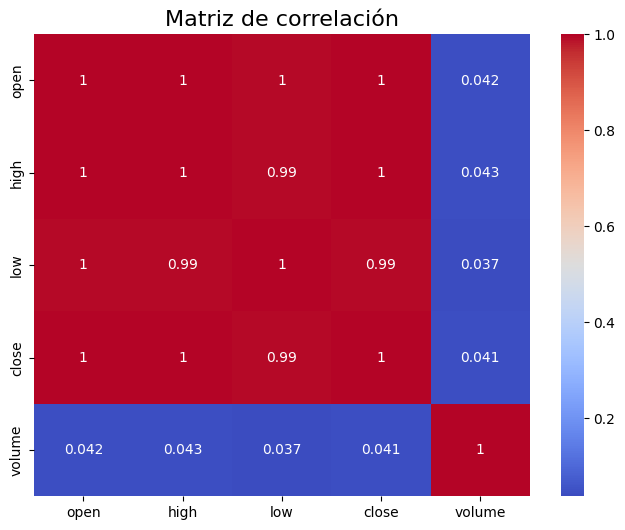

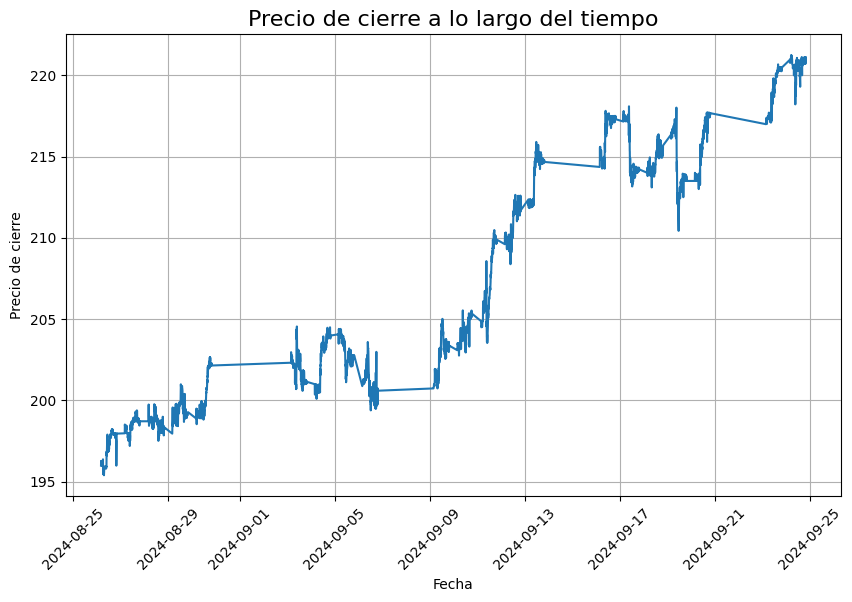

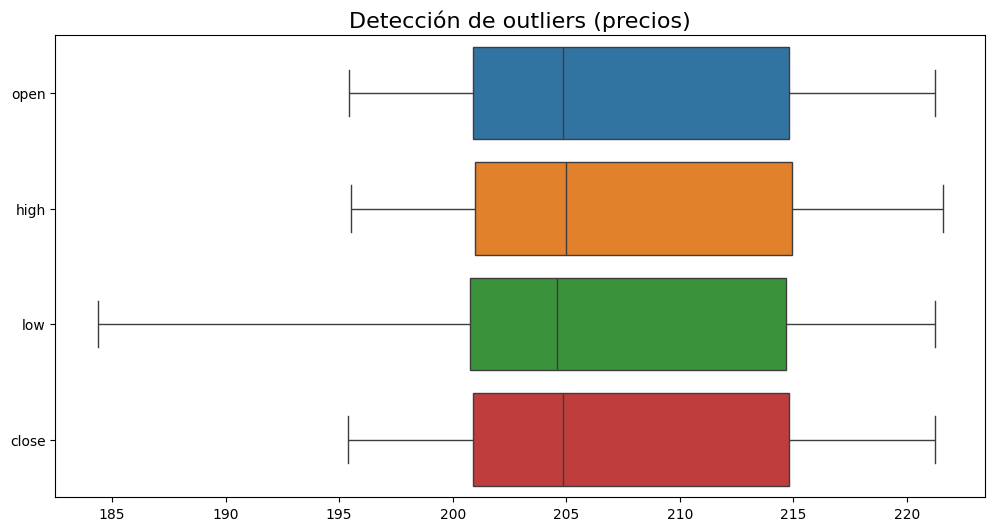

In [3]:
# --------------------------------------------------------------------------------
# 1. Análisis EDA
# --------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Estadísticas descriptivas básicas
print("Estadísticas descriptivas:")
print(data.describe())

# 1.2 Distribución de precios
plt.figure(figsize=(12, 6))
data[['open', 'high', 'low', 'close']].hist(bins=20, figsize=(10, 8))
plt.suptitle("Distribución de precios y volumen", fontsize=16)
plt.show()

# 1.3 Análisis de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(data[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación", fontsize=16)
plt.show()

# 1.4 Gráfico de series temporales
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['close'], label='Precio de cierre')
plt.title('Precio de cierre a lo largo del tiempo', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 1.5 Boxplot para detectar outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['open', 'high', 'low', 'close']], orient='h')
plt.title("Detección de outliers (precios)", fontsize=16)
plt.show()

# Preprocesamiento

In [4]:
# --------------------------------------------------------------------------------
# 2. Acciones de Preprocesamiento
# --------------------------------------------------------------------------------

# 2.1 Imputación de valores faltantes (si existen)
# Verificar si hay valores faltantes
print("\nValores faltantes en cada variable:")
print(data.isnull().sum())

# Si hubiera valores faltantes, podríamos imputarlos de la siguiente manera:
# data.fillna(method='ffill', inplace=True)


Valores faltantes en cada variable:
date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [5]:
# 2.2 Escalado de los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume']])
# Crear un nuevo DataFrame con las características escaladas
df_scaled = pd.DataFrame(scaled_features, columns=['open', 'high', 'low', 'close', 'volume'])
df_scaled['date'] = data['date']  # Mantener la columna de fecha intacta

In [6]:
# 2.3 Generación de nuevas características
data['price_range'] = data['high'] - data['low']  # Rango de precios
data['daily_change_pct'] = (data['close'] / data['open'] - 1) * 100  # Cambio porcentual diario

In [7]:
# 2.4 Eliminación de outliers
# Definir una función para eliminar outliers basados en el rango intercuartil (IQR)

def remove_outliers(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Aplicar la eliminación de outliers
df_cleaned = remove_outliers(data, ['open', 'high', 'low', 'close'])

# Visualizar el DataFrame limpio
print("\nDatos después de la eliminación de outliers:")
print(df_cleaned.head())


Datos después de la eliminación de outliers:
                 date    open    high     low   close  volume  price_range  \
0 2024-08-26 04:00:00  196.20  196.20  196.00  196.00     6.0          0.2   
1 2024-08-26 04:05:00  195.80  196.38  195.68  196.28   176.0          0.7   
2 2024-08-26 04:35:00  195.98  195.98  195.98  195.98    19.0          0.0   
3 2024-08-26 04:40:00  196.28  196.28  196.28  196.28     1.0          0.0   
4 2024-08-26 05:20:00  195.98  195.98  195.98  195.98     1.0          0.0   

   daily_change_pct  
0         -0.101937  
1          0.245148  
2          0.000000  
3          0.000000  
4          0.000000  


Como se puede observar no hay presencia de outliers

In [8]:
df_cleaned.shape

(3362, 8)

# Dividir datos en conjunto de entrenamiento y prueba
Usa las columnas relevantes como características (X):


In [9]:
!pip install scikit-learn # install the scikit-learn library that contains the train_test_split function
import pandas as pd # import pandas for data manipulation
from sklearn.model_selection import train_test_split # import the train_test_split function from the sklearn.model_selection module

df=df_cleaned
X = df[['open', 'high', 'low', 'volume','price_range','daily_change_pct']]
y = df['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modelos de Machine Learning

A partir de este apartado veremos como predecir el precio de cierre basándonos en las características históricas del precio (apertura, máximo, mínimo, volumen, Rango de precios y Cambio porcentual diario).



# Random Forest con ajuste de hiperparámetros

Se utiliza GridSearchCV para ajustar los hiperparámetros

In [10]:
#!pip install scikit-learn # install scikit-learn if it's not already installed
from sklearn.ensemble import RandomForestRegressor # import the RandomForestRegressor class
import numpy as np # import numpy
from sklearn.model_selection import GridSearchCV # import GridSearchCV
from sklearn.metrics import mean_squared_error # import the mean_squared_error function

rf = RandomForestRegressor()

# Definir los parámetros para la búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_search_rf.best_estimator_

# Predicciones
rf_preds = best_rf.predict(X_test)

# Evaluación
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print(f'Random Forest RMSE: {rf_rmse}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest RMSE: 1.6764193973079737


# XGBoost con ajuste de hiperparámetros

Se ajusta el modelo de XGBoost de manera similar:

In [11]:
!pip install xgboost # install xgboost if it's not already installed
from xgboost import XGBRegressor # import the XGBRegressor class

xgb = XGBRegressor(objective='reg:squarederror')

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Mejor modelo
best_xgb = grid_search_xgb.best_estimator_

# Predicciones
xgb_preds = best_xgb.predict(X_test)

# Evaluación
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print(f'XGBoost RMSE: {xgb_rmse}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost RMSE: 1.7683995296560373


# Modelos de Regresión
Veremos ahora algunos modelos de regresión, como la Regresión Lineal, Regresión Ridge y Regresión Lasso. Los implementaremos en el contexto de datos multivariados para IBM, junto con el ajuste de hiperparámetros y la validación cruzada.

# Importar bibliotecas adicionales

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score


# Regresión Lineal

Entrenamos y evaluamos el modelo de regresión lineal

In [13]:
# Regresión Lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones
lin_reg_preds = lin_reg.predict(X_test)

# Evaluación
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_preds))
print(f'Linear Regression RMSE: {lin_reg_rmse}')

# Validación cruzada
lin_reg_cv_scores = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
lin_reg_cv_rmse = np.sqrt(-lin_reg_cv_scores.mean())
print(f'Linear Regression CV RMSE: {lin_reg_cv_rmse}')


Linear Regression RMSE: 0.019788031835988817
Linear Regression CV RMSE: 0.012533755209441281


# Regresión Ridge

Ajusta y evalúa el modelo de regresión Ridge

In [14]:
# Regresión Ridge
ridge = Ridge()
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_ridge.fit(X_train, y_train)

# Mejor modelo
best_ridge = grid_search_ridge.best_estimator_

# Predicciones
ridge_preds = best_ridge.predict(X_test)

# Evaluación
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f'Ridge Regression RMSE: {ridge_rmse}')

# Validación cruzada
ridge_cv_scores = cross_val_score(best_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_cv_rmse = np.sqrt(-ridge_cv_scores.mean())
print(f'Ridge Regression CV RMSE: {ridge_cv_rmse}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Regression RMSE: 0.023282754238292125
Ridge Regression CV RMSE: 0.013568939076296126


# Regresión Lasso

Ajusta y evalúa el modelo de regresión Lasso

In [15]:
# Regresión Lasso
lasso = Lasso()
param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_lasso.fit(X_train, y_train)

# Mejor modelo
best_lasso = grid_search_lasso.best_estimator_

# Predicciones
lasso_preds = best_lasso.predict(X_test)

# Evaluación
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
print(f'Lasso Regression RMSE: {lasso_rmse}')

# Validación cruzada
lasso_cv_scores = cross_val_score(best_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_cv_rmse = np.sqrt(-lasso_cv_scores.mean())
print(f'Lasso Regression CV RMSE: {lasso_cv_rmse}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e+01, tolerance: 9.996e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e+01, tolerance: 1.058e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e+01, tolerance: 9.531e

Lasso Regression RMSE: 0.40666256028120723
Lasso Regression CV RMSE: 0.29621529930369767


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e+01, tolerance: 1.123e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.332e+01, tolerance: 1.836e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+01, tolerance: 1.493e

# Comparar los resultados
Aquí se compara el rendimiento de todos los modelos.

In [16]:
import pandas as pd

# Crear un DataFrame con los resultados
results = {
    'Modelo': ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
               'Random Forest', 'XGBoost'],
    'RMSE': [lin_reg_rmse, ridge_rmse, lasso_rmse, rf_rmse, xgb_rmse]
}

# Crear el DataFrame
results_df = pd.DataFrame(results)

# Ordenar el DataFrame por RMSE de menor a mayor
results_df_sorted = results_df.sort_values(by='RMSE')

# Mostrar el DataFrame ordenado
print("Resultados de RMSE de Modelos de Predicción (ordenados de menor a mayor):")
print(results_df_sorted)

Resultados de RMSE de Modelos de Predicción (ordenados de menor a mayor):
              Modelo      RMSE
0  Linear Regression  0.019788
1   Ridge Regression  0.023283
2   Lasso Regression  0.406663
3      Random Forest  1.676419
4            XGBoost  1.768400


# 6. Visualizar los resultados de regresión
También puedes visualizar las predicciones de los modelos de regresión junto con los demás modelos:

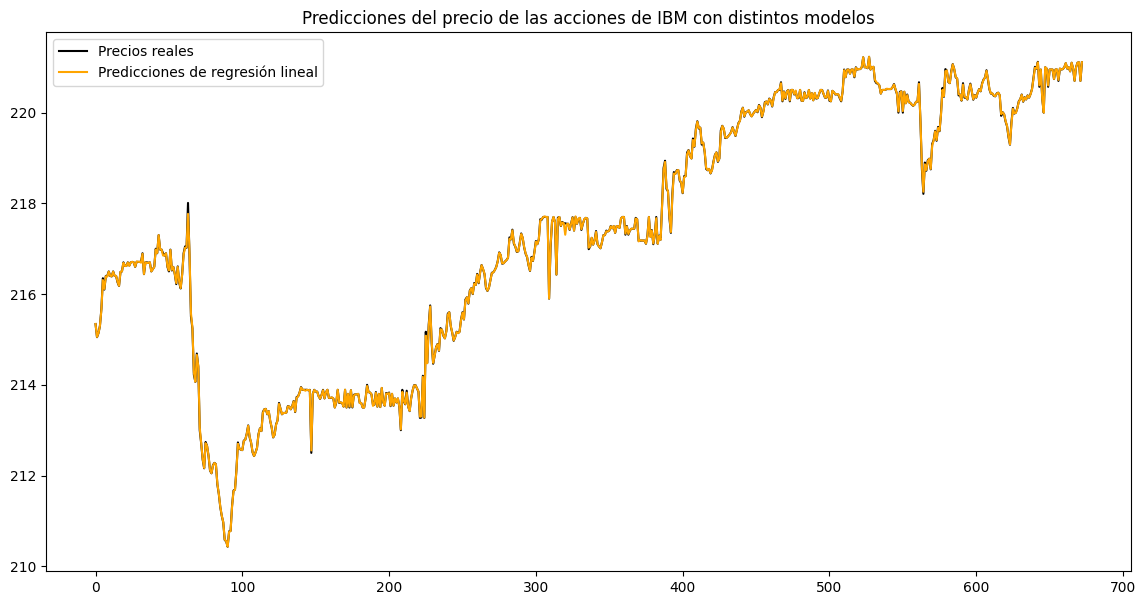

In [17]:
plt.figure(figsize=(14,7))
plt.plot(y_test.reset_index(drop=True), label='Precios reales', color='black')
plt.plot(lin_reg_preds, label='Predicciones de regresión lineal', color='orange')
#plt.plot(ridge_preds, label='Predicciones de regresión Ridge', color='purple')
#plt.plot(lasso_preds, label='Predicciones de regresión Lasso', color='brown')
#plt.plot(rf_preds, label='Predicciones Random Forest', color='blue')
#plt.plot(xgb_preds, label='Predicciones XGBoost', color='red')
plt.legend()
plt.title('Predicciones del precio de las acciones de IBM con distintos modelos')
plt.show()


# Conclusiones

Con base en los resultados de RMSE ordenados, se pueden sacar las siguientes conclusiones:

Linear Regression presenta el mejor desempeño con un RMSE de 0.019788, lo que indica que este modelo tiene la mayor precisión en la predicción de los precios de acciones para este conjunto de datos. Es un resultado esperado cuando las relaciones entre las variables son lineales.

Ridge Regression, con un RMSE de 0.023283, tiene un rendimiento muy cercano al de la regresión lineal estándar. Esto sugiere que la regularización aplicada por Ridge no tiene un impacto significativo en este caso, posiblemente porque las características no presentan problemas graves de multicolinealidad.

Lasso Regression muestra un RMSE significativamente mayor (0.406663), lo que indica que este modelo no es adecuado para este conjunto de datos. Esto podría deberse a que la regularización Lasso tiende a forzar a cero algunos coeficientes, lo que puede haber afectado la capacidad predictiva.

Random Forest y XGBoost tienen los peores rendimientos con RMSE de 1.676419 y 1.768400 respectivamente. Aunque estos modelos suelen ser robustos para predicciones no lineales y con características complejas, en este caso parecen haber tenido problemas para capturar la estructura de los datos, posiblemente debido a la naturaleza de los datos o a una falta de ajuste fino en los hiperparámetros.

Conclusión General:
Para este conjunto de datos y este problema específico, los modelos lineales (especialmente Linear Regression) han mostrado ser más efectivos que los modelos más avanzados como Random Forest y XGBoost.Esto podría indicar que la relación entre las variables predictoras y el precio de las acciones es principalmente lineal, y que los modelos más complejos no agregan valor adicional en este caso, e incluso pueden sobreajustarse a los datos.

Recomendación: Dado el rendimiento de los modelos, sería beneficioso centrarse en ajustar más modelos lineales y explorar técnicas de ingeniería de características o probar diferentes tipos de regularización. Además, podría ser útil realizar un ajuste más fino de hiperparámetros en los modelos más complejos si se quiere mejorar su rendimiento.